# GNES Flow API and Demo

> **NOTE:**
My experience is that Jupyter notebook seems not a stable environment for multiprocess and multithread appliation. Thus, I'm not setting replicas to any service. If you want to explore with `replicas > 1`, you may want to copy the code out to a standard `.py` file and run it there. If you encounter some problems when running this demo, please refer to [the troubleshooting guidlines]().

In this demo, we will use the new `gnes.flow` API (`gnes >= 0.0.46` is required) to build a toy image search system for indexing and retrieving flowers based on their similarities.

For those who aren't familiar with GNES. GNES `[jee-nes]` is Generic Neural Elastic Search, a cloud-native semantic search system based on deep neural network. GNES enables large-scale index and semantic search for text-to-text, image-to-image, video-to-video and any-to-any content form. More information can be found here: https://github.com/gnes-ai/gnes

## 1. Download InceptionV4 pretrained model and flowers data

#### Get InceptionV4

The pretrained model is available at here:
https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models

Decompress it and put it into `TEST_WORKDIR`

```bash
TEST_WORKDIR=/tmp/gnes-flow-demo/
mkdir ${TEST_WORKDIR}

curl http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz --output inception_v4_2016_09_09.tar.gz
tar -xvf inception_v4_2016_09_09.tar.gz
mv inception_v4.ckpt ${TEST_WORKDIR}
rm inception_v4_2016_09_09.tar.gz
```

Note `TEST_WORKDIR` will be later used in our YAML config.

#### Get flowers data

Get it from here: http://www.robots.ox.ac.uk/~vgg/data/flowers/17/

```bash
curl http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz --output 17flowers.tgz
mv 17flowers.tgz ${TEST_WORKDIR}
```

**No need to decompress the flower data**, we will read from it and feed to GNES directly.

In [1]:
import os
import tarfile
import random

os.environ['TEST_WORKDIR']='/tmp/gnes-flow-demo'

def read_flowers(sample_rate=1.0):
    with tarfile.open(os.path.join(os.environ['TEST_WORKDIR'], '17flowers.tgz')) as fp:
        for m in fp.getmembers():
            if m.name.endswith('.jpg') and random.random() <= sample_rate:
                yield fp.extractfile(m).read()

### (Optional) Check out those flowers

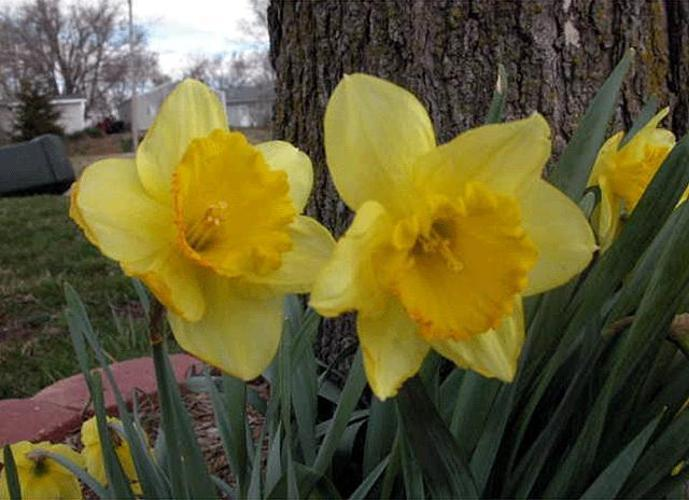

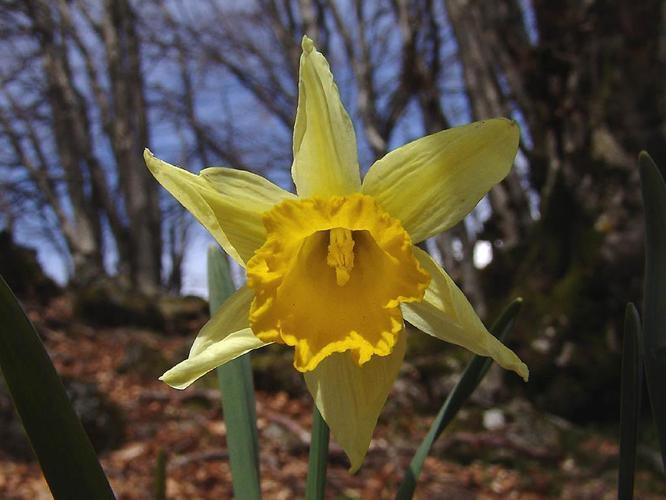

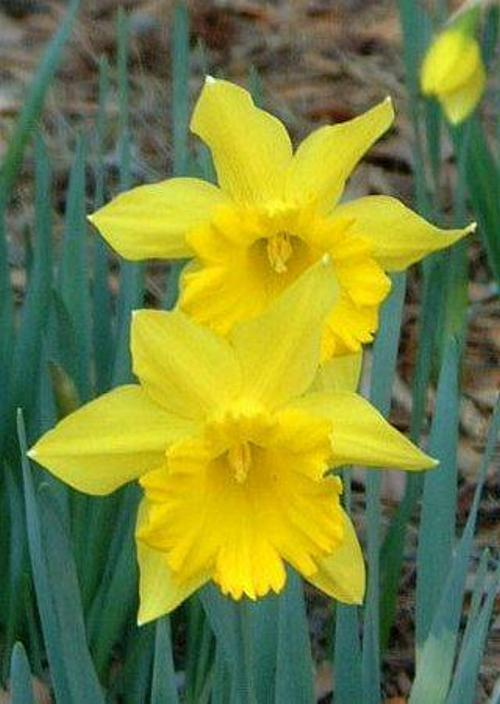

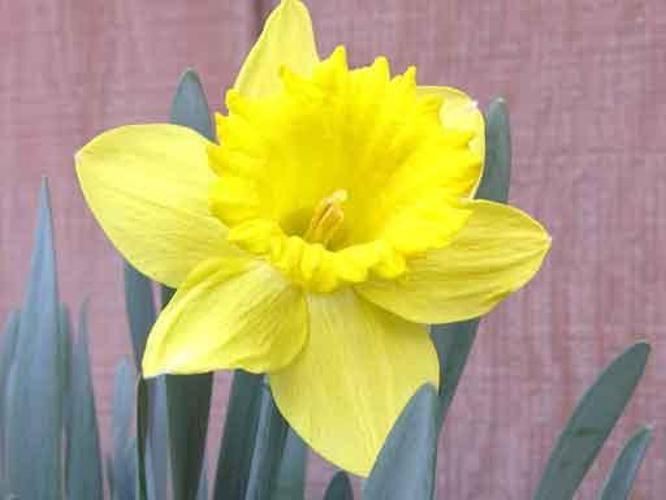

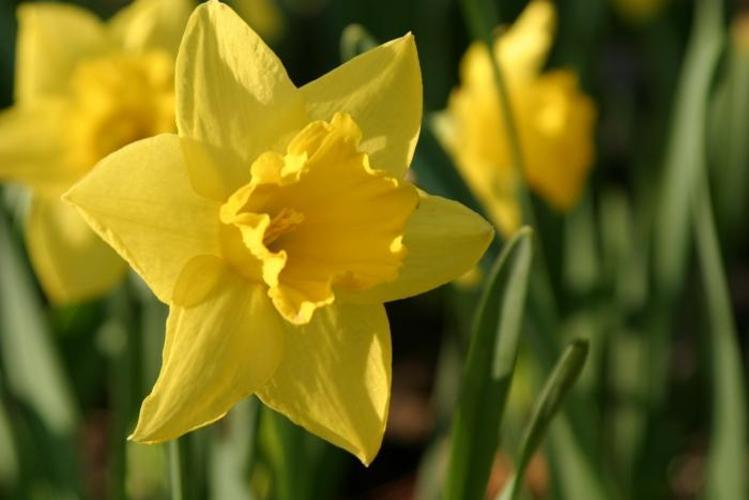

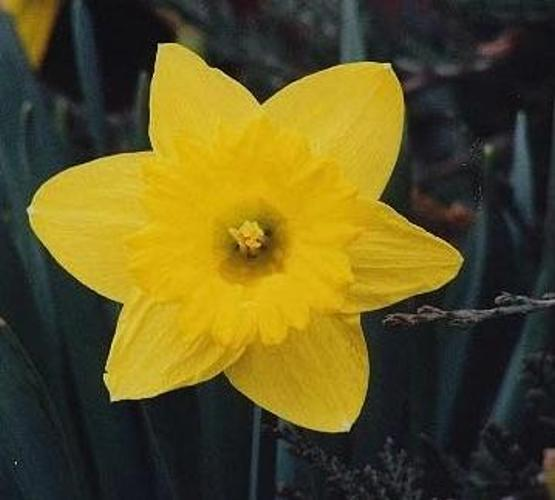

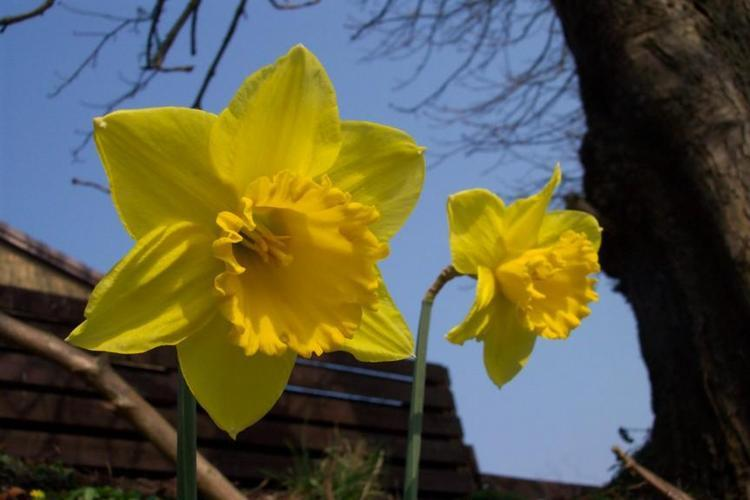

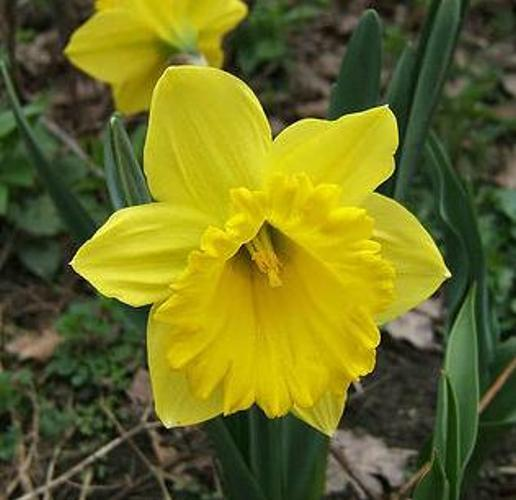

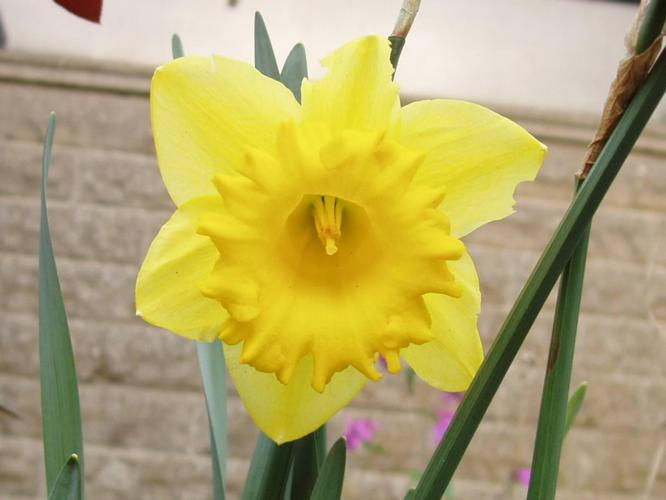

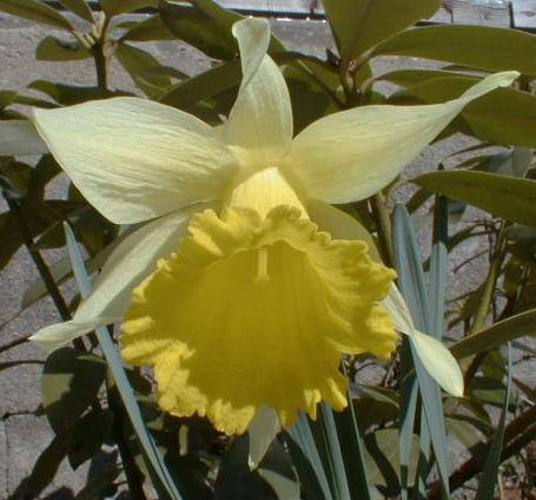

In [2]:
from IPython.display import Image
from IPython.display import display

reader = read_flowers()
samples = [Image(next(reader)) for v in range(10)]

display(*samples)

## 2. Build the GNES index flow

In [8]:
from gnes.flow import Flow
flow = (Flow(check_version=False)
        .add_preprocessor(name='prep', yaml_path='yaml/prep.yml')
        .add_encoder(yaml_path='yaml/incep.yml')
        .add_indexer(name='vec_idx', yaml_path='yaml/vec.yml')
        .add_indexer(name='doc_idx', yaml_path='yaml/doc.yml', recv_from='prep')
        .add_router(name='sync', yaml_path='BaseReduceRouter', num_part=2, recv_from=['vec_idx', 'doc_idx']))

W:Flow:[__i:_po:189]:this object is not named ("name" is not found under "gnes_config" in YAML config), i will call it "Flow-4b9561aa". naming the object is important as it provides an unique identifier when serializing/deserializing this object.


### (Optional) Visualizing the indexig workflow

So how is this flow look like?

We can visualize its topology by first `build` the flow and then generate the corresponding SVG image.

In [9]:
from IPython.display import IFrame
IFrame(src=flow.build(backend=None).to_url(), width=900, height=200)

W:Flow:[__i:bui:726]:no specified backend, build_level stays at GRAPH, and you can not run this flow.


## 3. Indexing data

Here I set the `batch_size=10` as I'm running this notebook on a single CPU machine, you can scale it up if you are running on a GPU machine.

Indexing the complete flowers dataset on CPU will takes about 10 min.

In [ ]:
with flow(backend='process') as fl:
    fl.index(bytes_gen=read_flowers(), batch_size=10)

## 4. Build the GNES query flow

In [10]:
from gnes.flow import Flow
flow = (Flow(check_version=False)
        .add_preprocessor(name='prep', yaml_path='yaml/prep.yml')
        .add_encoder(yaml_path='yaml/incep.yml')
        .add_indexer(name='vec_idx', yaml_path='yaml/vec.yml')
        .add_router(name='scorer', yaml_path='yaml/score.yml')
        .add_indexer(name='doc_idx', yaml_path='yaml/doc.yml'))

W:Flow:[__i:_po:189]:this object is not named ("name" is not found under "gnes_config" in YAML config), i will call it "Flow-63859ed4". naming the object is important as it provides an unique identifier when serializing/deserializing this object.


### (Optional) Visualizing the query workflow

Again, we first build the flow with no backend just to see how the query workflow looks like.

In [11]:
from IPython.display import IFrame
IFrame(src=flow.build(backend=None).to_url(), width=900, height=200)

W:Flow:[__i:bui:726]:no specified backend, build_level stays at GRAPH, and you can not run this flow.


## 5. Querying data

Everything is ready, we are now able to query from all indexed images using GNES. In this demo, we simply sample some flower images and checkout their top-k similar ones.

In [13]:
num_q = 20
topk = 10
sample_rate = 0.05

# do the query
results = []
with flow.build(backend='process') as fl:
    for q, r in fl.query(bytes_gen=read_flowers(sample_rate)):
        q_img = q.search.query.raw_bytes
        r_imgs = [k.doc.raw_bytes for k in r.search.topk_results]
        r_scores = [k.score.value for k in r.search.topk_results]
        results.append((q_img, r_imgs, r_scores))
        if len(results) > num_q:
            break

I:FrontendService:[fro:__i: 40]:start a frontend with 10 workers
C:FrontendService:[fro:__e: 49]:listening at: 0.0.0.0:8800
I:PreprocessorService:[bas:_ru:424]:bind sockets...
I:PreprocessorService:[bas:_ru:431]:control over tcp://0.0.0.0:60097
I:PreprocessorService:[bas:_ru:435]:input 0.0.0.0:60383
I:PreprocessorService:[bas:_ru:439]:output 0.0.0.0:51554
I:PreprocessorService:[bas:_ru:445]:input 0.0.0.0:60383	 output 0.0.0.0:51554	 control over tcp://0.0.0.0:60097
W:GNES:[__i:reg: 41]:fail to register AudioVanilla, due to "No module named 'soundfile'", you will not be able to use this model
W:GNES:[__i:reg: 41]:fail to register PyTorchTransformers, due to "No module named 'torch'", you will not be able to use this model
W:UnaryPreprocessor:[__i:_po:189]:this object is not named ("name" is not found under "gnes_config" in YAML config), i will call it "UnaryPreprocessor-c716b6be". naming the object is important as it provides an unique identifier when serializing/deserializing this obje

INFO:tensorflow:Restoring parameters from /tmp/gnes-flow-demo/inception_v4.ckpt


C:TFInceptionEncoder:[__i:_ge:369]:initialize TFInceptionEncoder from a yaml config
C:EncoderService:[bas:_ru:455]:ready and listening
I:IndexerService:[bas:_ru:424]:bind sockets...
I:IndexerService:[bas:_ru:431]:control over tcp://0.0.0.0:63388
I:IndexerService:[bas:_ru:435]:input 0.0.0.0:59278
I:IndexerService:[bas:_ru:439]:output 0.0.0.0:63917
I:IndexerService:[bas:_ru:445]:input 0.0.0.0:59278	 output 0.0.0.0:63917	 control over tcp://0.0.0.0:63388
W:GNES:[__i:reg: 41]:fail to register PyTorchTransformers, due to "No module named 'torch'", you will not be able to use this model
C:NumpyIndexer:[__i:_ge:352]:restore NumpyIndexer from /tmp/gnes-flow-demo/my_vec_indexer.bin
C:IndexerService:[bas:_ru:455]:ready and listening
I:RouterService:[bas:_ru:424]:bind sockets...
I:RouterService:[bas:_ru:431]:control over tcp://0.0.0.0:49702
I:RouterService:[bas:_ru:435]:input 0.0.0.0:63917
I:RouterService:[bas:_ru:439]:output 0.0.0.0:60773
I:RouterService:[bas:_ru:445]:input 0.0.0.0:63917	 output

I:RouterService:[hel:__e:315]:handling message takes 0.009 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.034 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.015 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.009 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.028 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.013 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.010 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.035 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.016 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.009 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.031 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.014 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.010 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.030 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.011 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.009 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.033 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.012 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

I:RouterService:[hel:__e:315]:handling message takes 0.009 secs
I:IndexerService:[bas:_ho:410]:a message in type: response with route: FrontendService▸PipelinePreprocessor▸TFInceptionEncoder▸NumpyIndexer▸Chunk2DocTopkReducer▸DictIndexer
I:MessageHandler:[bas:cal:260]:received a 'QueryResponse' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_doc_search
I:IndexerService:[hel:__e:315]:handling message takes 0.027 secs
I:ZmqClient:[bas:__i: 81]:current libzmq version is 4.3.2,  pyzmq version is 18.1.0
I:ZmqClient:[bas:__i: 93]:input 0.0.0.0:49503	 output 0.0.0.0:60383
I:PreprocessorService:[bas:_ho:410]:a message in type: request with route: FrontendService▸PipelinePreprocessor
I:MessageHandler:[bas:cal:260]:received a 'QueryRequest' message
I:MessageHandler:[bas:cal:269]:handling message with _handler_query
I:PreprocessorService:[hel:__e:315]:handling message takes 0.013 secs
I:EncoderService:[bas:_ho:410]:a message in type: request with route: FrontendService▸Pipeli

### Plot the results

To visualize the results, we now convert the returned images into thumbnails, otherwise the images are too big for `matplotlib` to visualize.

In [18]:
import io
import numpy as np
from PIL import Image

def bytes2ndarray(i, max_size=48):
    img = Image.open(io.BytesIO(i))
    img.thumbnail((max_size, max_size))
    return np.asarray(img)

# converts raw_bytes to 48x48 thumbnails for visualization
results_v = [(bytes2ndarray(q_img), [bytes2ndarray(r) for r in r_imgs], r_scores) for q_img, r_imgs, r_scores in
             results]

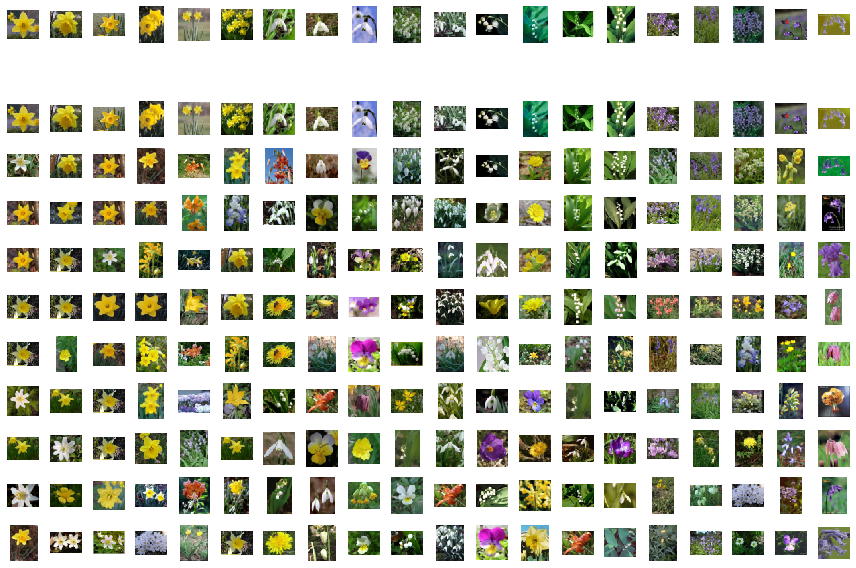

In [38]:
# plot
import matplotlib.pyplot as plt

plt.close()
# first row: query. empty space for separation, 3rd to last: topk-results
f, ax = plt.subplots(topk + 2, num_q, figsize=(12, 8))

for q in range(num_q):
    ax[0][q].imshow(results_v[q][0])
    for r in range(topk):
        ax[r + 2][q].imshow(results_v[q][1][r])

# do some layout things
[aa.axis('off') for a in ax for aa in a]
plt.tight_layout()
plt.show()